<img src='https://s15.postimg.org/huiifx2mz/Copy_of_logo_with_white_background.png'>

<center>
# Clustering
## A Brief Introduction
### By Ben Bowman

<par>
Last week we went over _Classification_.  _Classification_ problems occur when you are trying to _categorize_ objects given known features about them and class labels.  _Classification_ is an example of _supervised learning_.  This week, we will be going over **Clustering**, the analogue of Classification in _unsupervised learning_.  

<par>
**Clustering** involves _grouping_ objects based on some similarity between their characteristics.  The notion of similarity depends on how the problem is defined.  For example, in today's demonstration the notion of similarity we will use is based on geometric distance, where we conceptualize the objects as points living in Euclidean space and group these points into _clusters_ based on their distance from each other using a common distance metric. (Note: in this case, the way the distance metric is defined determines your notion of similarity)

### Applications

* Grouping customers into _market segments_ for the purpose of targeting groups of customers
* Clustering users into social groups on social networking sites
* Segmenting an image into different objects in computer vision
* Marking different types of tissue in a PET scan

_See More_: https://en.wikipedia.org/wiki/Cluster_analysis#Applications

#### Quote on Unsupervised Learning

"When we’re learning to see, nobody’s telling us what the right answers are — we just
look. Every so often, your mother says “that’s a dog”, but that’s very little information.
You’d be lucky if you got a few bits of information — even one bit per second — that
way. The brain’s visual system has $10^{14}$ neural connections. And you only live for $10^9$
seconds. So it’s no use learning one bit per second. You need more like $10^5$ bits per
second. And there’s only one place you can get that much information: from the input
itself." — Geoffrey Hinton, 1996 (quoted in (Gorder 2006)) 

Seen in the book _Machine Learning: A Probabilistic Perspective_ by Kevin P. Murphy

# Let's get right to it 
We will be using the same data that we did in the Classification presentation except we will ignore the class labels temporarily. [Iris Dataset](http://archive.ics.uci.edu/ml/datasets/Iris)

In [3]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#make plots interactive within notebook
%matplotlib notebook

### Import The Data

In [4]:
data = pd.read_csv('bezdekIris.data', names=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Class'])
data = data.iloc[np.random.permutation(len(data))] #Shuffle the data
data = data.reset_index(drop=True) #Reset the indices
data.head(10)

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.9,3.0,5.1,1.8,Iris-virginica
1,5.4,3.0,4.5,1.5,Iris-versicolor
2,5.0,3.5,1.3,0.3,Iris-setosa
3,5.6,3.0,4.5,1.5,Iris-versicolor
4,4.9,2.5,4.5,1.7,Iris-virginica
5,4.5,2.3,1.3,0.3,Iris-setosa
6,6.9,3.1,4.9,1.5,Iris-versicolor
7,5.6,2.7,4.2,1.3,Iris-versicolor
8,4.8,3.4,1.6,0.2,Iris-setosa
9,6.4,3.2,4.5,1.5,Iris-versicolor


# Exploring our Data

Let us first probe our data to see if any values are missing and get some descriptive statistics for each feature.

In [5]:
# Sepal Length
print 'Missing Sepal Length Values: ' + str(data['Sepal Length'].isnull().sum())
data['Sepal Length'].describe()

Missing Sepal Length Values: 0


count    150.000000
mean       5.843333
std        0.828066
min        4.300000
25%        5.100000
50%        5.800000
75%        6.400000
max        7.900000
Name: Sepal Length, dtype: float64

In [6]:
#Sepal Width
print 'Missing Sepal Width Values: ' + str(data['Sepal Width'].isnull().sum()) 
data['Sepal Width'].describe()

Missing Sepal Width Values: 0


count    150.000000
mean       3.057333
std        0.435866
min        2.000000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.400000
Name: Sepal Width, dtype: float64

In [7]:
#Petal Length
print 'Missing Petal Length Values: ' + str(data['Petal Length'].isnull().sum())
data['Petal Length'].describe()

Missing Petal Length Values: 0


count    150.000000
mean       3.758000
std        1.765298
min        1.000000
25%        1.600000
50%        4.350000
75%        5.100000
max        6.900000
Name: Petal Length, dtype: float64

In [8]:
#Petal Width
print 'Missing Petal Width Values: ' + str(data['Petal Width'].isnull().sum())
data['Petal Width'].describe()

Missing Petal Width Values: 0


count    150.000000
mean       1.199333
std        0.762238
min        0.100000
25%        0.300000
50%        1.300000
75%        1.800000
max        2.500000
Name: Petal Width, dtype: float64

We see that we have no values missing.  **_This almost never happens in practice_**.  Nonetheless, in this case, we can proceed without cleaning our data.

#### Now it's time to take a look at our method

### K-Means

Suppose we have a data set containing $n$ observations $(x_1, x_2, \ldots, x_n)$.  We want to divide our data into $k$ clusters.  We select $k$ points, $(m_1, m_2, \ldots, m_k)$, either at random or with some deliberation to serve as our initial '$k$ means' for our $k$ clusters.  We then form clusters around each of these $k$ means by assigning each point $x_r$ to the cluster corresponding to the $m_i$ that it is closest to.  We do this to form a set of Clusters $\{C_1, C_2, \ldots, C_k\}$ where
$C_i = \{x_r : d(x_r, m_i) \le d(x_r, m_j), 1 \le i,j \le k, 1 \le r \le n \}$ where $d(x, y)$ is the distance function.  $$d(x,y) := \left ( \sum_{i} (x^{(i)} - y^{(i)})^2 \right ) ^{\frac{1}{2}} $$  We then recompute the means $(m_1, m_2, \ldots, m_k)$ to be the _centroids_ of the new clusters.
$$m_i =  \frac{1}{|C_i|} \sum_{x_j \in C_i} x_j$$

where $|C_i|$ is the number of points in the set $C_i$.
The above formula simply computes the coordinate-wise arithmetic mean of the points in the cluster.  We repeat this procedure until the means $(m_1, m_2, \ldots, m_k)$ stop changing from step-to-step.

Read more: https://en.wikipedia.org/wiki/K-means_clustering

### Experimenting with K-Means

Let's see the K-Means method in action.  Try changing the parameters att1, att2, att3, and num_clusters.  Observe how the method clusters the data.  Make note of what you see.

<IPython.core.display.Javascript object>


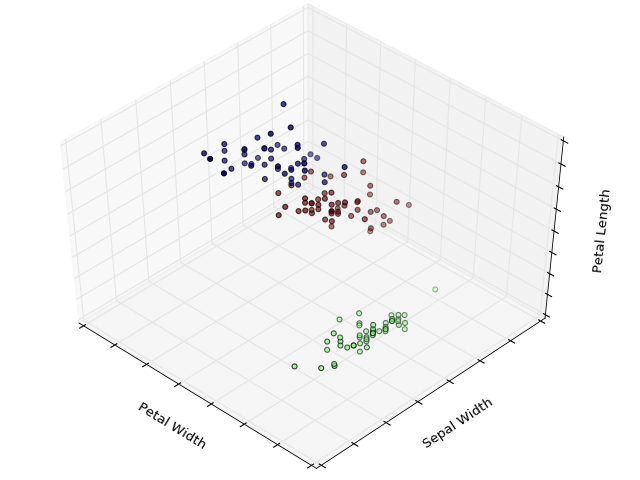

In [9]:
# Code modified from source: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py
# Original authors: Gaël Varoquaux, Jaques Grobler

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

np.random.seed(7)

# Select 3 attributes from: 'Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'
att1 = 'Petal Width'
att2 = 'Sepal Width'
att3 = 'Petal Length'
#Select the number of clusters
num_clusters = 3

X = data[[att1, att2, att3]].values
y = data['Class'].values

est = KMeans(n_clusters=num_clusters) #select number of clusters
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
est.fit(X)
labels = est.labels_

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel(att1)
ax.set_ylabel(att2)
ax.set_zlabel(att3)

plt.show() # Show figure

### Let's compare the clusters to the actual flower classes

<IPython.core.display.Javascript object>


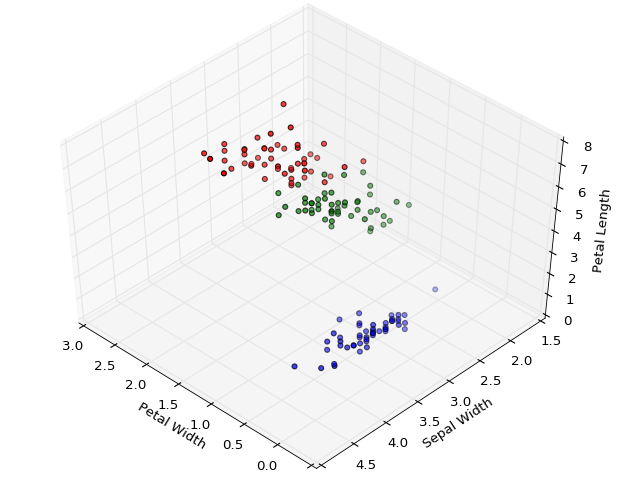

In [10]:
# Get a list of our classes Setosa, Versicolor, Virginica
classes = data.Class.unique()

# Pick colors for our classes
colormap = np.array(['r', 'g', 'b']) 

# Assign colors to each point depending on class
classColors = map(lambda x: np.where(classes==x)[0], data['Class'].values)


# Pull the attribute columns
X = data[att1]
Y = data[att2]
Z = data[att3]

# Create 3-d figure
fig = plt.figure(2, figsize=(8,6))
plt.clf,
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

# Make a colored scatter-plot
ax.scatter(X.values, Y.values, Z.values, c=colormap[classColors])

# Set our labels
ax.set_xlabel(att1)
ax.set_ylabel(att2)
ax.set_zlabel(att3)

plt.show() # Show figure


How did the method do?  When you set num_clusters = 3, do the clusters mirror the flower species?

### Testing the Accuracy of Our Method

From the above graphs it appears that the K-Means method worked pretty well.  Let's go over some concrete metrics to evaluate our performance.

### Evaluation

To evaluate the k-means method, we will set $k=3$ and see how well the clusters fit the different iris types.  Note: this kind of evaluation is only possible when you have class labels, oftentimes you do not.

### Rand Index

The evaluation metric we will be using is called the _Rand Index_.  It is as follows:

$$\textrm{Rand Index} = \frac{TP + TN}{TP + FP + TN + FN} \\~\\
TP = \textrm{True Positive} \\
TN = \textrm{True Negative} \\
FP = \textrm{False Positive} \\
FN = \textrm{False Negative} \\
$$

The Rand Index is a metric that we compute for each individual cluster.

In [59]:
import numpy as np
import collections
import itertools
from sklearn.cluster import KMeans

# Select 3 attributes from: 'Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width' to build model
att1 = 'Petal Width'
att2 = 'Sepal Width'
att3 = 'Petal Length'
#Select the number of clusters
num_clusters = 3

X = data[[att1, att2, att3]].values #grab data
y = data['Class'].values #grab classes

est = KMeans(n_clusters=num_clusters)
est.fit(X) # Determine clusters

combined = zip(y, est.labels_) #To compare results with actual
virginicaLabels = collections.Counter([x[1] for x in combined if x[0] == 'Iris-virginica']).most_common() 
setosaLabels = collections.Counter([x[1] for x in combined if x[0] == 'Iris-setosa']).most_common()
versicolorLabels = collections.Counter( [x[1] for x in combined if x[0] == 'Iris-versicolor']).most_common()
results = [virginicaLabels, setosaLabels, versicolorLabels]

for i, name in enumerate(['virginica', 'setosa', 'versicolor']):
    print 'Results for', name 
    #calculate true positives
    tp = results[i][0][1]
    others = results[0:i] + results[i+1:]
    #calculate true negatives
    tn = sum([x[1] for x in list(itertools.chain.from_iterable(others)) if x[0] != results[i][0][0]]) 
    print 'Rand-Index =', float(tp + tn) / len(X)
    print

Results for virginica
Rand-Index = 0.953333333333

Results for setosa
Rand-Index = 1.0

Results for versicolor
Rand-Index = 0.953333333333



Looks like our model did pretty well!  This was a very light introduction to Clustering.  There are plenty of ways to go from here!  

Resources:

* https://en.wikipedia.org/wiki/Cluster_analysis 
* https://en.wikipedia.org/wiki/K-means_clustering 
* http://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf 
* http://www.cad.zju.edu.cn/home/zhx/csmath/lib/exe/fetch.php?media=2011:presentation_ml_by_ibrar.pdf 